In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import statsmodels.api as sm #arima model
import warnings
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('/kaggle/input/2020-dacon-cup/train.csv',encoding = 'euc-kr')
sub = pd.read_csv("/kaggle/input/2020-dacon-cup/submission.csv", encoding = 'euc-kr')
sub1 = pd.read_csv("/kaggle/input/2020-dacon-cup/submission.csv", encoding = 'euc-kr')
train['DateTime'] = pd.to_datetime(train.DateTime)
date_time = pd.to_datetime(train.DateTime)
train['date'] = train.DateTime.dt.date
train = train.groupby(train['date']).sum().reset_index()

# Plot columns

In [3]:
def dacon_rmse(true, pred):  
    w0 = 1095.214646
    w1 = 1086.728535
    w2 = 268.070707
    w3 = 24236.194444
    score = (np.sqrt(np.mean(np.square(true[:,0] - pred[:,0]))) / w0 + 
               np.sqrt(np.mean(np.square(true[:,1] - pred[:,1]))) / w1 + 
               np.sqrt(np.mean(np.square(true[:,2] - pred[:,2]))) / w2 + 
               np.sqrt(np.mean(np.square(true[:,3] - pred[:,3]))) / w3  )
    return score

## Prophet model

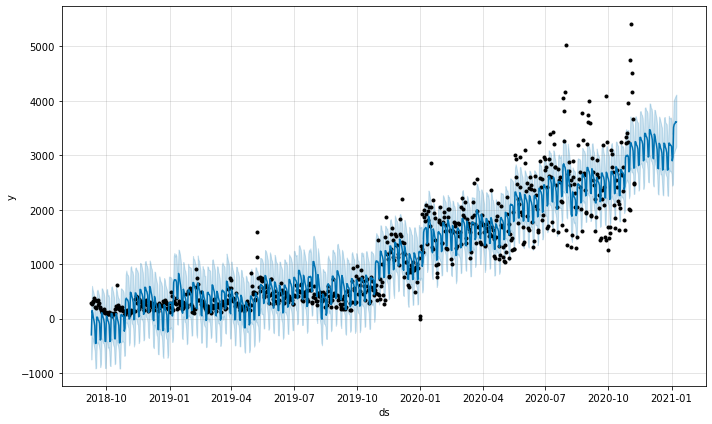

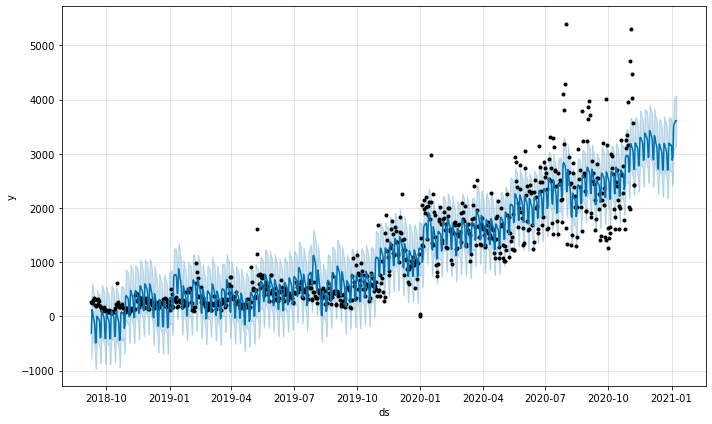

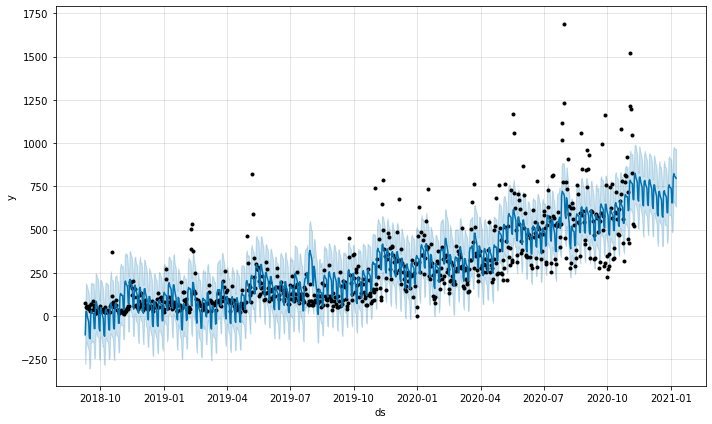

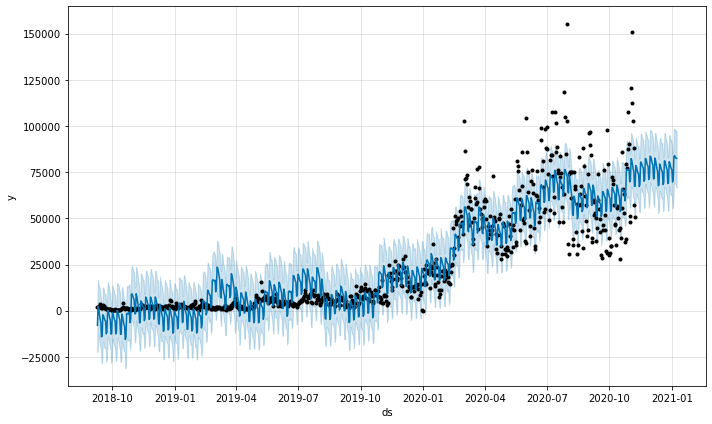

In [4]:
#changepoint_range=0.8
results = []
for col in train.columns[1:]:
    df=train[['date',col]]
    df=df.rename(columns = {'date': 'ds',col: 'y'})
    my_model = Prophet(changepoint_prior_scale=0.01,changepoint_range=0.9,
                       seasonality_prior_scale=0.5, holidays_prior_scale=1.0,
                      yearly_seasonality=20,weekly_seasonality=7,seasonality_mode='additive')
    my_model.fit(df)
    future_dates = my_model.make_future_dataframe(periods = 61)
    forecast = my_model.predict(future_dates)
    my_model.plot(forecast)
    sub[col]=forecast['yhat'].tail(n=61).values

In [5]:
sub.head(3)

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,3250.844304,3199.039880,816.887126,78582.219487
1,2020-11-10,3242.648027,3191.651805,824.790799,77797.699401
2,2020-11-11,3188.064820,3140.198951,801.180291,75950.205302


## SARIMAX model

In [6]:
for col in train.columns[1:]:
    mod = sm.tsa.SARIMAX(train[col],  order=(3,0,1), seasonal_order=(2,0,0,7))
    results= mod.fit()  
    sub1[col]=results.predict(start =  792, end= 852, dynamic= True).values

In [7]:
for col in sub.columns[1:]:
    sub[col]=(sub[col]+sub1[col])/2

In [8]:
sub6 = pd.read_csv("../input/2020-dacon-cup/submission-6.csv", encoding = 'euc-kr')
sub['사용자']=sub6['사용자']

In [9]:
sub.to_csv('sub_arima.csv',index=False, encoding = 'euc-kr')